In [3]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import signature.tensor_algebra as ta
from simulation.diffusion import Diffusion

import matplotlib
my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + jnp.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Goal: Model stationary path-dependence

Our goal is to develop a tool for which would allow us efficiently treat general time-invariant path-dependent models. By **time-invaraince** we will understand the dependence
$$
Y_t = F((X_{s})_{-\infty < s \leq t}),
$$
for some function $F: C(\mathbb{R}^-, \mathbb{R}) \to \mathbb{R}$.
This means that $Y_t$ depends only on the past path of $X$, but not on the time variable $t$ itself.

##### Generating the underlying Brownian motion:

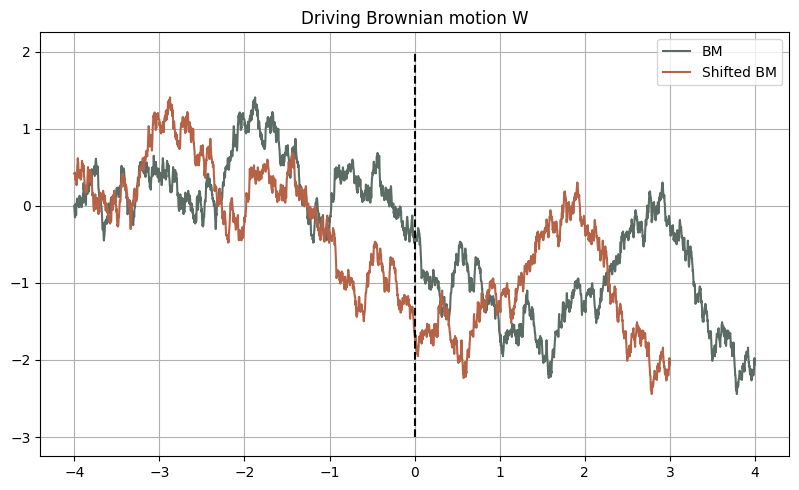

In [5]:
T = 4

t_grid = jnp.linspace(-T, T, (T * 2) * 365 + 1)
rng = np.random.default_rng(seed=4843)
size = 10

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]

fig, ax = plt.subplots()

shift = 365
ax.plot(t_grid, W, label="BM")
ax.plot(t_grid[:-shift], W[shift:], label="Shifted BM")
ax.vlines(0, -3, 2, "k", ls='--')
ax.legend()
ax.set_title("Driving Brownian motion W")

fig.tight_layout()
# fig.savefig("shifted_signal.pdf", format="pdf", transparent=True)

We denote the shifted (brown) trajectory by $\widetilde W = (W_{t +1})_{t \in \mathbb{R}}$.

The condition of time-invariance implies that $F((\widetilde W)_{s \leq 3}) = F((W)_{s \leq 4})$.

### EFM-Signature definition

The stationarity assumption is natural for many applications. However, it cannot be applied to the standard signature models. Indeed, the definition  of $\mathbb{X}_t$ can be seen as a Taylor expansion of path in the neighborhood of the time origin $t = 0$. 
- The presence of this time origin $t_0 = 0$ makes the time-invariance condition inapplicable due to the finiteness and variability of its length $t$.
- Hence, it is natural to suppose that at time $t$, the path is observable from infinitely distant time $-\infty$ to $t$.

For the integrals to be defined, we damp the integrators $\circ dX_u$ by $e^{-\lambda(t - u)}$ for some positive $\lambda > 0$:

$$
	\mathbb{X}^{\lambda, n}_{t}= \int_{-\infty < u_{1} < \ldots < u_{n} < t}^{}  e^{ -\lambda(t-u_{1}) }\otimes \circ dX_{u_{1}} \ldots e^{ -\lambda(t-u_{n}) }\otimes \circ dX_{u_{n}} 
$$

The **EFM-signature** is then given by $\mathbb{X}^{\lambda}_{t} = \left(\mathbb{X}^{\lambda, n}_{t}\right)_{n \geq 0}.$

Similarly, we can define
$$
	\mathbb{X}^{\lambda, n}_{s, t}= \int_{s < u_{1} < \ldots < u_{n} < t}^{}  e^{ -\lambda(t-u_{1}) }\otimes \circ dX_{u_{1}} \ldots e^{ -\lambda(t-u_{n}) }\otimes \circ dX_{u_{n}} 
$$
and $\mathbb{X}^{\lambda}_{s, t} = \left(\mathbb{X}^{\lambda, n}_{s, t}\right)_{n \geq 0}.$

### Computing the EFM-signature for $\widehat W_t = (t, W_t)$

- It is important to observe the signal for $t < 0$ for the signature on $[0, T]$ to be stationary.
- In practice, we take the path on $[T_0, T]$ for some $T_0 < 0$, compute the stationary signature $\widehat{\mathbb{W}}^{\lambda}_{t}$ and keep its values only for $t > 0$.

In [6]:
t_grid_pos = t_grid[t_grid >= 0]
W_pos = W[t_grid >= 0]

path = np.vstack([t_grid, W]).T
path_pos = np.vstack([t_grid_pos, W_pos]).T
dim = path.shape[1]

In [7]:
%%time
N = 10
Sig = ta.path_to_signature(path=path_pos, trunc=N)

CPU times: user 24.5 ms, sys: 10.4 ms, total: 35 ms
Wall time: 34.1 ms


In [8]:
%%time
lam = jnp.array([10])
SigS = ta.path_to_fm_signature(path=path, trunc=N, t_grid=t_grid, lam=lam)

CPU times: user 5 s, sys: 183 ms, total: 5.18 s
Wall time: 5.1 s


### Some nice properties

- The words ${\color{NavyBlue}{\mathbf{2}}}^{\otimes k}$ correspond to $\frac{Y_{t}^{k}}{k!}$, where $Y$ is a stationary OU process defined by $Y_{t} = \int_{-\infty}^{t} e^{ -\lambda(t-s) } \, dW_{s}$.
-  The words ${\color{NavyBlue}{\mathbf{1}}}^{\otimes k}$ correspond to constants $\frac{\lambda^{-k}}{k!}$.
-  The words ${\color{NavyBlue}{\mathbf{1}}}^{\otimes (k-1)}{\color{NavyBlue}{\mathbf{2}}}$ can be interpreted as exponential moving averages of $dW$ with different coefficients $k\lambda$.

In [9]:
# Define some basic words
e = ta.AlgebraBasis(trunc=N, dim=2)

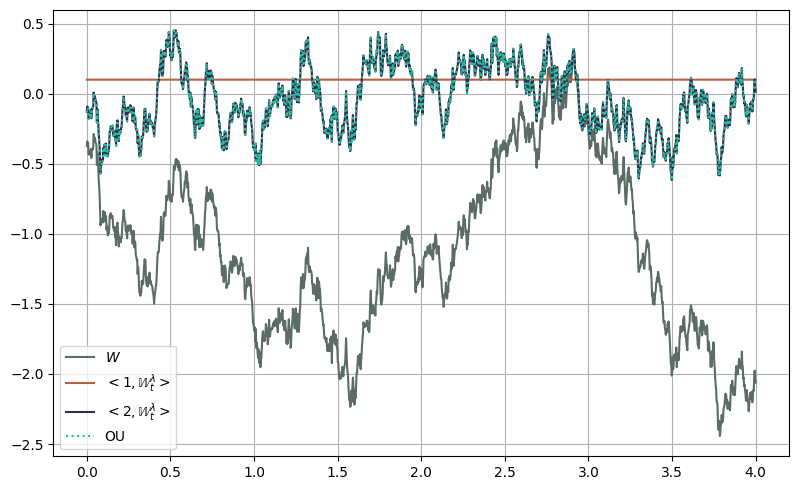

In [10]:
ou = diffusion.ornstein_uhlenbeck(lam=float(lam[0]), theta=0, sigma=1)[0, 0, :]

fig, ax = plt.subplots()
ax.plot(t_grid_pos, W_pos, label="$W$")
ax.plot(t_grid_pos, e[1] @ SigS, label="$<1, {\mathbb{W}}_{t}^{\lambda}>$")
ax.plot(t_grid_pos, e[2] @ SigS, label="$<2, {\mathbb{W}}_{t}^{\lambda}>$")
ax.plot(t_grid_pos, ou[t_grid >= 0], ":", label="OU")
ax.legend()

### More properties

An operator $\mathcal{\Lambda}\colon T((\mathbb{R}^d)) \to T((\mathbb{R}^d))$ is defined by
$$
\mathcal{\Lambda}\colon\ \boldsymbol{\ell} = (\boldsymbol{\ell}^n)_{n\geq 0} \mapsto \mathcal{\Lambda}\boldsymbol{\ell} = (n\boldsymbol{\ell}^n)_{n\geq 0}.
$$

For $\lambda > 0$ and $h \geq 0$, we define an operator $\mathcal{D}_h^\lambda$ by
\begin{align}
    \mathcal{D}_h^\lambda \colon\
    \boldsymbol{\ell} = (\boldsymbol{\ell}^n)_{n \geq 0} \mapsto \mathcal{D}_h^\lambda \boldsymbol{\ell} = (e^{-n\lambda h}\boldsymbol{\ell}^n)_{n \geq 0}.
\end{align}

- EFM-signature satisfies the following SDE: $$
    d\mathbb{X}^{\lambda}_{t} = -\lambda \mathcal{\Lambda} \mathbb{X}^{\lambda}_{t}\,dt + \mathbb{X}^{\lambda}_{t}\otimes\circ dX_t.$$
- Chen's identity: $$ \mathbb{X}^{\lambda}_{s, t} = (\mathcal{D}_{t - u}^\lambda\mathbb{X}^{\lambda}_{s, u}) \otimes \mathbb{X}^{\lambda}_{u, t}.$$
- Shuffle property: $$\left\langle{ \boldsymbol{\ell},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle \left\langle{ \boldsymbol{\psi},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle =\left\langle{ \boldsymbol{\ell}\mathrel{\sqcup \mkern -3.2mu \sqcup} \boldsymbol{\psi},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle.$$
- Expected signature $\mathcal{E}^\lambda = \mathbb{E}\mathbb{X}^{\lambda}_{t}$ and $\mathcal{E}_t^\lambda = \mathbb{E}\mathbb{X}^{\lambda}_{0, t}$ can be calculated explicitly.

In [11]:
SigS_T = SigS.subsequence((-1, ))           # Taking the EFM-Sig at t = T
D_SigS_T = ta.D(ts=SigS_T, dt=T, lam=lam)   # Computing D_dt^lam(SigS_T)
Lam_SigS_T = ta.G(ts=SigS_T, lam=lam)       # Computing Lambda(SigS_T)

Verifying the Chen's identity:

In [12]:
u_index = t_grid.size * 3 // 4
u = t_grid[u_index]
SigS_u_T = ta.path_to_fm_signature(path=path[u_index:], trunc=N, t_grid=t_grid[u_index:], lam=lam).subsequence((-1, ))
SigS_u = ta.path_to_fm_signature(path=path[:u_index + 1], trunc=N, t_grid=t_grid[:u_index + 1], lam=lam).subsequence((-1, ))
err = SigS_T - ta.tensor_prod(ta.D(ts=SigS_u, dt=T - u, lam=lam), SigS_u_T)
np.max(np.abs(err.array))

9.801983823718235e-09

### Regression of coefficients

We want to estimate $\boldsymbol{\ell}$ observing a signal $Y$, which is supposed to be a linear combination
$$Y_t = \left\langle{ \boldsymbol{\ell},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle$$

As an example, we consider $S_t = \dfrac{1}{1.01 + \sin(Z_t)}$, where
$$
dZ_t = \kappa (\theta - Z_t) dt + \nu dW_t,
$$
and do the linear regression of $S_t$ against $\mathbb{W}_{t}^{\lambda}$.

Text(0.5, 1.0, 'Signal')

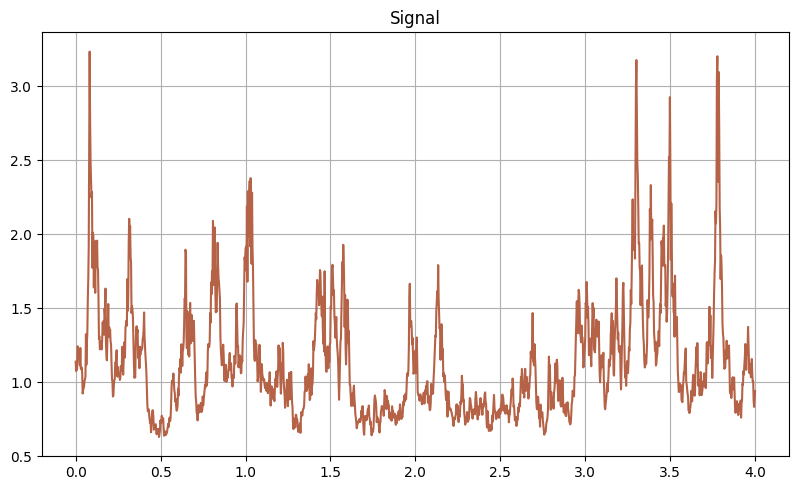

In [13]:
kappa = 15
theta = 0.
nu = 1.5

rng = np.random.default_rng(seed=4843)
diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)

ou_mu = diffusion.ornstein_uhlenbeck(lam=kappa, theta=theta, sigma=nu)[0, 0, :]
signal = 1 / (1.01 + np.sin(ou_mu)[t_grid >= 0])

fig, ax = plt.subplots()
ax.plot(t_grid_pos, signal, color=my_copper)
ax.set_title("Signal")

In [14]:
from sklearn.linear_model import LinearRegression, Ridge

trunc = 3
dim = 2
n_params = int(ta.number_of_words_up_to_trunc(trunc, dim))  # number of signature elements of order <= trunc

in_sample_T = 1
in_sample_idx = (t_grid_pos <= in_sample_T)

eps = 0.0001
# Linear regression on signature features
lin_reg_sig = Ridge(alpha=eps, fit_intercept=False)
lin_reg_sig.fit(X=Sig.array.T[in_sample_idx, :n_params], y=signal[in_sample_idx])

# Linear regression on EFM-signature features
lin_reg_efm = Ridge(alpha=eps, fit_intercept=False)
lin_reg_efm.fit(X=SigS.array.T[in_sample_idx, :n_params], y=signal[in_sample_idx])

eps = 10
# Ridge regression on signature features
ridge_sig = Ridge(alpha=eps, fit_intercept=False)
ridge_sig.fit(X=Sig.array.T[in_sample_idx, :n_params], y=signal[in_sample_idx])

# Linear regression on EFM-signature features
ridge_efm = Ridge(alpha=eps, fit_intercept=False)
ridge_efm.fit(X=SigS.array.T[in_sample_idx, :n_params], y=signal[in_sample_idx])

Ridge(alpha=10, fit_intercept=False)

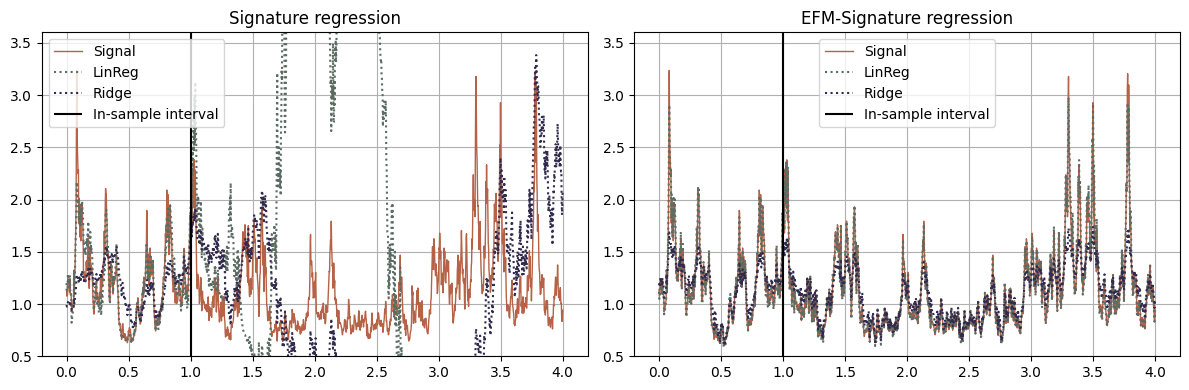

In [15]:
lim_a = 0.5
lim_b = 3.6

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_grid_pos, signal, color=my_copper, lw=1, label="Signal")
ax[0].plot(t_grid_pos, lin_reg_sig.predict(Sig.array.T[:, :n_params]), ":", color=my_green,  label="LinReg")
ax[0].plot(t_grid_pos, ridge_sig.predict(Sig.array.T[:, :n_params]), ":", color="#322B4D", label="Ridge")
ax[0].vlines(x=in_sample_T, ymin=lim_a, ymax=lim_b, color="k", label="In-sample interval")
ax[0].set_ylim([lim_a, lim_b])
ax[0].set_title("Signature regression")
ax[0].legend()

ax[1].plot(t_grid_pos, signal, color=my_copper, lw=1, label="Signal")
ax[1].plot(t_grid_pos, lin_reg_efm.predict(SigS.array.T[:, :n_params]), ":", color=my_green, label="LinReg")
ax[1].plot(t_grid_pos, ridge_efm.predict(SigS.array.T[:, :n_params]), ":", color="#322B4D", label="Ridge")
ax[1].vlines(x=in_sample_T, ymin=lim_a, ymax=lim_b, color="k", label="In-sample interval")
ax[1].set_ylim([lim_a, lim_b])
ax[1].set_title("EFM-Signature regression")
ax[1].legend()

fig.tight_layout()
# fig.savefig("signature_regression.pdf", format="pdf", transparent=True)

- Signature regression does not work well out-of-sample because of it non-stationarity and explosive behavior when $t \to \infty$.

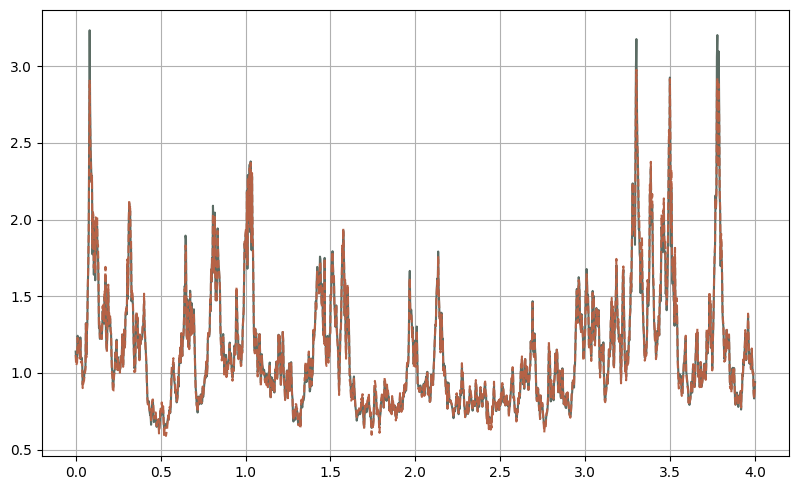

In [16]:
# transforming the regression coefficients into a tensor sequence
arr = jnp.array(lin_reg_efm.coef_, dtype=jnp.float64)
l_reg_efm = ta.from_array(array=arr, trunc=N, dim=2)
plt.plot(t_grid_pos, signal)
plt.plot(t_grid_pos, l_reg_efm @ SigS, "--")
plt.show()

### Prediction of signal

Using the Chen's identity and the expected signature, one can compute the conditionally expectations and variances:
\begin{equation}
        \mathbb{E}[Y_{t+h} \,|\, \mathbb{F}_t] = \left\langle \boldsymbol{\ell}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle, \quad \mathbb{V}\mathrm{ar}[Y_{t+h} \,|\, \mathbb{F}_t] = \left\langle \boldsymbol{\ell}^{\mathrel{\sqcup \mkern -3.2mu \sqcup} 2}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle - \left\langle \boldsymbol{\ell}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle^2.
\end{equation}

In [17]:
%%time
dt = jnp.diff(t_grid_pos)[0]
eSigS_dt = ta.expected_bm_stationary_signature(trunc=N, lam=lam, t=dt)

CPU times: user 3.01 s, sys: 77 ms, total: 3.09 s
Wall time: 3.07 s


In [19]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=2) # precomputing shuffle products for the base elements

In [20]:
t_grid_pred = t_grid_pos[t_grid_pos > in_sample_T]

t0_idx = jnp.where(t_grid_pos <= in_sample_T)[0][-1]
t = t_grid_pos[t0_idx]
SigS_t = SigS.subsequence(jnp.array([t0_idx]))

signal_pred = jnp.zeros_like(t_grid_pred)
signal_pred_std = jnp.zeros_like(t_grid_pred)
l_reg_efm_sq = ta.shuffle_pow(l_reg_efm, 2, shuffle_table=shuffle_table)
for i in range(t_grid_pred.size):
    SigS_t = ta.tensor_prod(ta.D(SigS_t, dt, lam), eSigS_dt)
    signal_pred = signal_pred.at[i].set(SigS_t @ l_reg_efm)
    signal_pred_std = signal_pred_std.at[i].set(np.sqrt(SigS_t @ l_reg_efm_sq - signal_pred[i]**2))

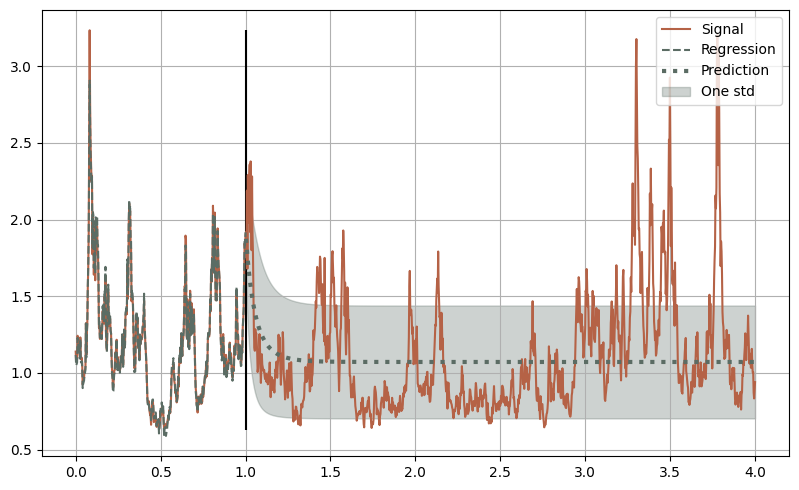

In [21]:
fig, ax = plt.subplots()
ax.vlines(x=in_sample_T, ymin=np.min(signal), ymax=np.max(signal), color="k")
ax.plot(t_grid_pos, signal, color=my_copper, label="Signal")
ax.plot(t_grid_pos[t_grid_pos <= in_sample_T], (SigS @ l_reg_efm).real[t_grid_pos <= in_sample_T], "--", color=my_green, label="Regression")
ax.plot(t_grid_pred, signal_pred, ":", color=my_green, label="Prediction", lw=3)
ax.fill_between(t_grid_pred, signal_pred - signal_pred_std, signal_pred + signal_pred_std, color=my_green, alpha=0.3, label="One std")
# ax.set_title("Prediction of signal given $\mathcal{F}_t$")
ax.legend(loc=1)

fig.tight_layout()
fig.savefig("signature_prediction.pdf", format="pdf", transparent=True)

### Multi-factor EFM-Signature

The **EFM-signature** can be used to capture memory effects at multiple time scales via considering different values of $\lambda$ per channel.
 Namely, fix ${\lambda} = (\lambda^1, \ldots, \lambda^d)$. The elements of the EFM-sgianture are then given by
$$
	\mathbb{X}^{\lambda, i_1\ldots i_n}_{s, t}= \int_{s < u_{1} < \ldots < u_{n} < t}^{}  e^{ -\lambda^{i_1}(t-u_{1}) } \circ dX_{u_{1}}^{i_1} \ldots e^{ -\lambda^{i_n}(t-u_{n}) } \circ dX_{u_{n}}^{i_n}
$$

In [22]:
%%time
N_3d = 5

path_3d = np.vstack([t_grid, W, W]).T # Duplicating the Brownian motion component
lam_3d = jnp.array([5, 50, 5])
SigS_3d = ta.path_to_fm_signature(path=path_3d, trunc=N_3d, t_grid=t_grid, lam=lam_3d)

CPU times: user 2.86 s, sys: 99.8 ms, total: 2.96 s
Wall time: 2.91 s


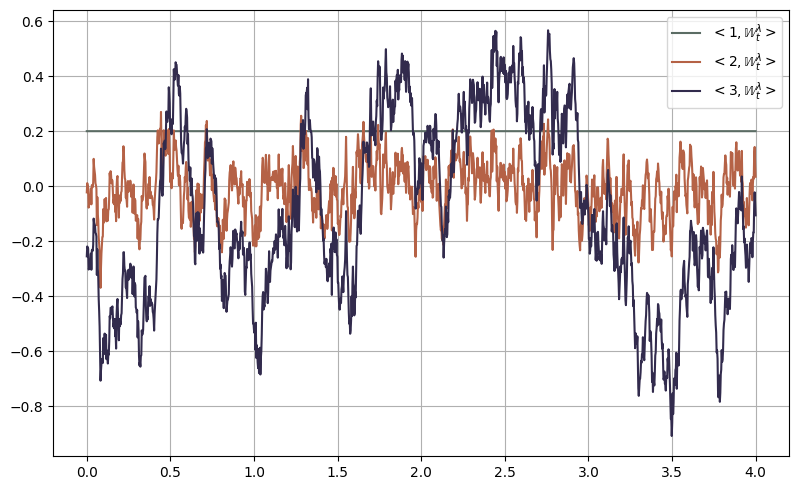

In [23]:
e_3d = ta.AlgebraBasis(trunc=N_3d, dim=3)

fig, ax = plt.subplots()
ax.plot(t_grid_pos, e_3d[1] @ SigS_3d, label="$<1, {\mathbb{W}}_{t}^{\lambda}>$")
ax.plot(t_grid_pos, e_3d[2] @ SigS_3d, label="$<2, {\mathbb{W}}_{t}^{\lambda}>$")
ax.plot(t_grid_pos, e_3d[3] @ SigS_3d, label="$<3, {\mathbb{W}}_{t}^{\lambda}>$")

ax.legend()